In [1]:
from PIL import ImageFont, ImageDraw, Image
from fontTools.ttLib import TTFont
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import multiprocessing

In [2]:
VOCAB = 28; BATCH_SIZE = 256

## Load Font

In [3]:
class Glyph(object):
    # transform character to bitmap
    def __init__(self, fonts, size=64):
        # load fonts, size. We will use 2 fonts for all CJK characters, so keep 2 codepoint books.
        self.codepoints = [set() for _ in fonts]
        self.size = int(size * 0.8)
        self.size_img = size
        self.pad = (size - self.size) // 2
        self.fonts = [ImageFont.truetype(f, self.size) for f in fonts]
        # use a cache to reduce computation if duplicated characters encountered.
        self.cache = {}
        for cp, font in zip(self.codepoints, fonts):
            font = TTFont(font)
            # store codepoints in font cmap into self.codepoints
            for cmap in font['cmap'].tables:
                if not cmap.isUnicode():
                    continue
                for k in cmap.cmap:
                    cp.add(k)
    
    def draw(self, ch):
        if ch in self.cache:
            return self.cache[ch]
        # search among fonts, use the first found
        exist = False
        for i in range(len(self.codepoints)):
            if ord(ch) in self.codepoints[i]:
                font = self.fonts[i]
                exist = True
                break
        if not exist:
            return None

        img = Image.new('L', (self.size_img, self.size_img), 0)
        draw = ImageDraw.Draw(img)
        (width, baseline), (offset_x, offset_y) = font.font.getsize(ch)
        draw.text((self.pad - offset_x, self.pad - offset_y + 4), ch, font=font, fill=255, stroke_fill=255) 
        img_array = np.array(img.getdata(), dtype='float32').reshape((self.size_img, self.size_img)) / 255
        self.cache[ch] = img_array

        return img_array

In [4]:
glyphbook = Glyph(['data/fonts/HanaMinA.otf', 'data/fonts/HanaMinB.otf'], size=128)

In [5]:
def _mapping(item):
    char, code, dup_total, dup_curr = item
    glyph = glyphbook.draw(char)
    if glyph is not None:
        return glyph, code, dup_total, dup_curr

def preprocess_chart(chart, cores=multiprocessing.cpu_count()):
    glyphs = []; codes = []
    dup_total = []; dup_curr = []
    with multiprocessing.Pool(processes=cores) as pool:
        for item in pool.map(_mapping, chart.values):
            if item is not None:
                glyphs.append(item[0])
                codes.append(item[1])
                dup_total.append(item[2])
                dup_curr.append(item[3])
    return np.expand_dims(np.array(glyphs), -1), np.array(codes), np.array(dup_total), np.array(dup_curr)

In [6]:
def tokenizer(code_table):
    # Cangjie code consists only of a-z, with maximum length of 5, minimum of 1
    # start with 0, a-z are 1-26, end and padding are 27
    tokens = np.expand_dims(np.zeros(code_table.shape, dtype='int64'), -1)
    code_index = list(map(lambda x: list(map(lambda y: ord(y) - 96, list(x))) + [27] * (5-len(x)), code_table))
    tokens = np.append(tokens, np.array(code_index), axis=-1)
    return tokens

In [7]:
code_chart = pd.read_csv('data/cangjie6.txt', delimiter='\t', header=None, names=['Char', 'Code'], keep_default_na=False)

In [8]:
count = {}
for char, code in code_chart.values:
    if char in count:
        count[char].append(code)
        count[char].sort(key=len)
        count[char].sort(key=lambda x: (len(x), x))
    else:
        count[char] = [code]

In [9]:
MAX_LEN = code_chart.Code.map(len).max()
MAX_DUP = max(map(lambda x: len(x), count.values()))

In [10]:
code_chart['DuplicateTotal'] = code_chart['Char'].map(count).map(len).copy()
code_chart['DuplicateCurrent'] = code_chart.apply(lambda x: count[x['Char']].index(x['Code']) + 1, axis=1).copy()

In [11]:
glyphs, codes, dups_total, dups_curr = preprocess_chart(code_chart)
tokens = tokenizer(codes)
lengths = np.array([len(list(filter(lambda i: i < VOCAB - 1 and i > 0, x))) for x in tokens])
lengths = np.array([np.identity(MAX_LEN)[i-1] for i in lengths], dtype='int64')
dups_total = np.array([np.identity(MAX_DUP)[i-1] for i in dups_total], dtype='int64')
dups_curr = np.array([np.identity(MAX_DUP)[i-1] for i in dups_curr], dtype='int64')
del code_chart, codes, count

In [12]:
(train_glyphs, validation_glyphs,
 train_tokens, validation_tokens,
 train_lengths, validation_lengths,
 train_dups_total, validation_dups_total,
 train_dups_curr, validation_dups_curr) = train_test_split(
    glyphs, tokens, lengths, dups_total, dups_curr, test_size=0.1, random_state=902)
del glyphs, tokens, lengths, dups_total, dups_curr

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((train_glyphs, train_tokens, train_lengths, train_dups_total, train_dups_curr))
dataset = dataset.shuffle(train_glyphs.shape[0]).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((validation_glyphs, validation_tokens, validation_lengths, validation_dups_total, validation_dups_curr))
val_dataset = val_dataset.shuffle(validation_glyphs.shape[0]).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

del train_glyphs, validation_glyphs, train_tokens, validation_tokens, train_lengths, validation_lengths
del train_dups_total, validation_dups_total, train_dups_curr, validation_dups_curr

## Load Model

In [14]:
cangjie = tf.saved_model.load('./Cangjie_Model/')

## Testing

In [15]:
@tf.function
def correctness_probs(glyph_tensor, target, length, total_dups, curr_dups):
    features = cangjie.encode(glyph_tensor)
    dups_pred = cangjie.predict_duplicates(features)
    length_pred = cangjie.predict_length(features, dups_pred, curr_dups)

    # calculate accuracy based on the code's whole string
    predictions_id, probabilities = cangjie.decode(features, length_pred, dups_pred, curr_dups)
    correct = tf.math.reduce_all(predictions_id == target, 1)
    wrong = tf.math.logical_not(correct)
    
    true_glyphs = tf.boolean_mask(glyph_tensor, correct)
    false_glyphs = tf.boolean_mask(glyph_tensor, wrong)
    true_target = tf.boolean_mask(target, correct)
    false_target = tf.boolean_mask(target, wrong)
    false_predicted = tf.boolean_mask(predictions_id, wrong)
    true_probs = tf.boolean_mask(probabilities, correct)
    false_probs = tf.boolean_mask(probabilities, wrong)
    
    return true_glyphs, false_glyphs, true_target, false_target, false_predicted, true_probs, false_probs

In [16]:
def decode(indexes):
    code = ''
    for i in indexes:
        if i <= 0:
            continue
        elif i >= 27:
            break
        else:
            code += chr(i + 96)
    return code
def display_char(glyphs, true_tokens, pred_tokens, probs):
    columns = 8
    num_last = glyphs.shape[0] % columns
    rows = glyphs.shape[0] // columns + (1 if num_last > 0 else 0)
    plt.figure(figsize=(2 * columns, 2.5 * rows))
    for i in range(rows):
        for j in range(columns if i < rows - 1 or num_last == 0 else num_last):
            plt.subplot(rows, columns, i * columns + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(glyphs[i * columns + j,:,:,0], cmap='Greys')
            plt.xlabel(f'True: {decode(true_tokens[i * columns + j])}\nPredicted: {decode(pred_tokens[i * columns + j])}\nProb: {probs[i * columns + j]:.2%}')
    plt.show()

In [17]:
true_glyphs = np.empty([0, 128, 128, 1]); false_glyphs = np.empty([0, 128, 128, 1]); true_targets = np.empty([0, 6], dtype='int');
false_targets = np.empty([0, 6], dtype='int'); false_predicteds = np.empty([0, 6], dtype='int'); true_probs = np.empty([0]); false_probs = np.empty([0])
for (batch, (glyph_tensor, target, length, total_dups, curr_dups)) in enumerate(val_dataset, start=1):
    print(f'Processing batch {batch}', end='\r')
    true_glyph, false_glyph, true_target, false_target, false_predicted, true_prob, false_prob = correctness_probs(
        glyph_tensor, target, length, total_dups, curr_dups)
    true_glyphs = np.append(true_glyphs, true_glyph, axis=0)
    false_glyphs = np.append(false_glyphs, false_glyph, axis=0)
    true_targets = np.append(true_targets, true_target, axis=0)
    false_targets = np.append(false_targets, false_target, axis=0)
    false_predicteds = np.append(false_predicteds, false_predicted, axis=0)
    true_probs = np.append(true_probs, true_prob, axis=0)
    false_probs = np.append(false_probs, false_prob, axis=0)

In [18]:
for i in range(1, 10):
    print('{}th percentile: correct predictions {:.2%}, wrong predictions {:.2%}'.format(
        10*i, np.percentile(true_probs, 10*i), np.percentile(false_probs, 10*i)))

10th percentile: correct predictions 80.51%, wrong predictions 30.44%
20th percentile: correct predictions 93.65%, wrong predictions 41.37%
30th percentile: correct predictions 97.60%, wrong predictions 49.30%
40th percentile: correct predictions 98.99%, wrong predictions 55.59%
50th percentile: correct predictions 99.49%, wrong predictions 62.55%
60th percentile: correct predictions 99.73%, wrong predictions 71.55%
70th percentile: correct predictions 99.86%, wrong predictions 80.28%
80th percentile: correct predictions 99.93%, wrong predictions 89.46%
90th percentile: correct predictions 99.97%, wrong predictions 96.40%


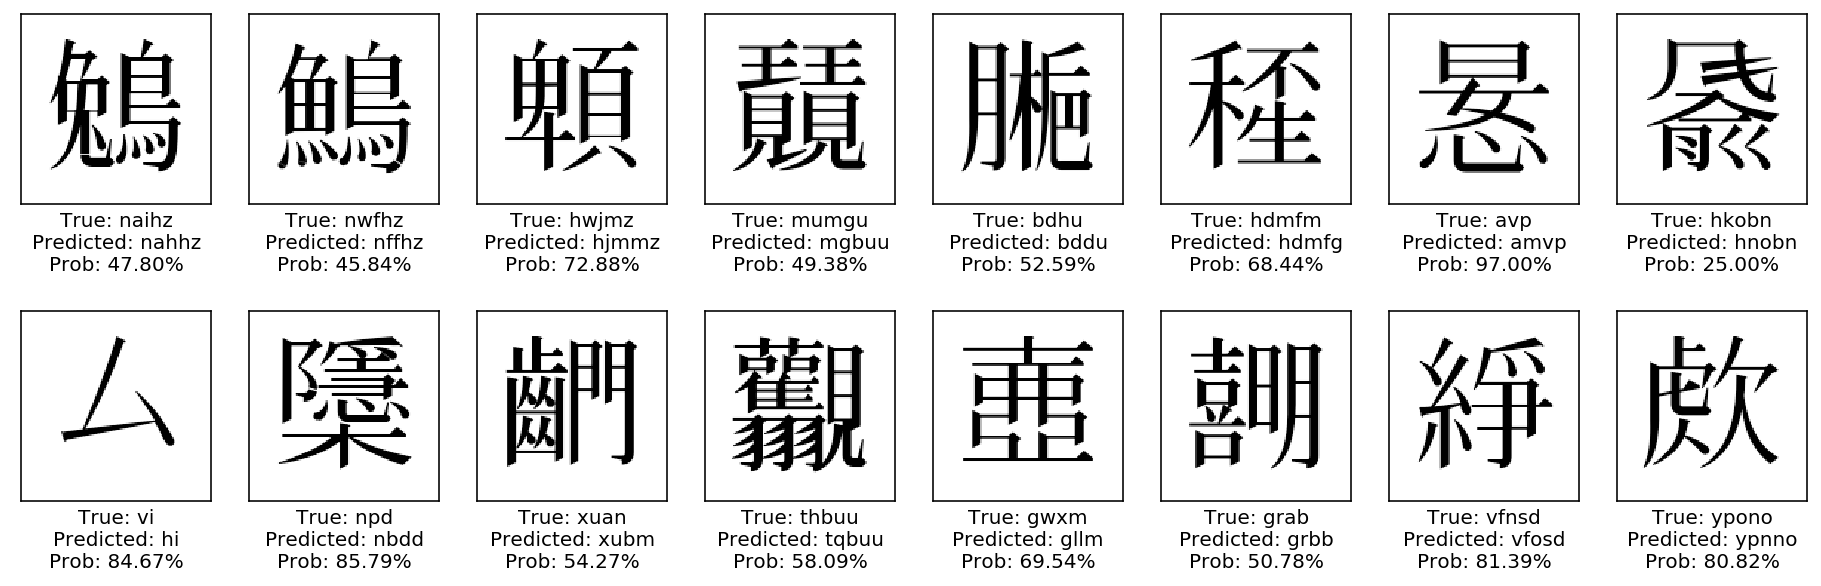

In [19]:
display_char(false_glyphs[:16], false_targets[:16], false_predicteds[:16], false_probs[:16])